In [ ]:
# Installing implementetion of very good net
!pip install efficientnet_pytorch
!pip install torchensemble
!pip install GPUtil

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms, utils
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
import copy
from efficientnet_pytorch import EfficientNet
from torchensemble import VotingClassifier
from GPUtil import showUtilization as gpu_usage
from numba import cuda 
from google.colab import files

We have used modified code from pytorch tutorials examples: 

*   https://pytorch.org/tutorials/beginner/basics/intro.html?fbclid=IwAR39fLmciD387r-6dhUb9d8nSLF3Tj47mV80sJC2kT_YWbY0CjKjDDtt2rM
*   https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html?fbclid=IwAR2eiC3u2l9ixcuX4QMwpUhSd27--yROhs2aJbQauOI6IeNo2Wj5Xh5V8_8



In [ ]:
# setting up gpu computing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

cpu


In [ ]:
np.exp(1e5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


inf

In [ ]:
# decorator for time measuring
def measuretime(func):
    def wrapper():
        starttime = time.perf_counter()
        func()
        endtime = timer.perf_counter()
        print(f"Time needed: {endtime - starttime} seconds")
        return wrapper

# Datasets


In [ ]:
# Settings
num_classes = 10
batch_size = 64
num_epochs = 5

# loading CIFAR-10 data and transforming it to tensors
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders_dict = {'train':trainloader, 'val':testloader}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
file_path = "/content/drive/MyDrive/Projekt-DL/"

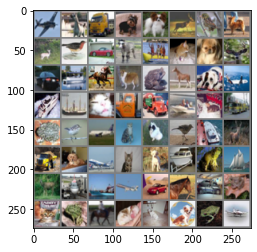

plane horse truck   dog


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# functions to show and save an image
def imshowsave(img, where):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig(where)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# Helper Functions

# Function for training model from scrath, fine tuning and feature extraction
def train_model(model, criterion, optimizer, num_epochs=5,
                num_print=2000, sched=False, batch_score=False,
                dataloaders=dataloaders_dict):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    stopping_rule_satisfied = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # Scheduler for optimizing learning rate
    if sched:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max=num_epochs)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for i, data in enumerate(dataloaders[phase], 1):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if i % 1000 == 0 and sched:
                            scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # print loss each batch
                if i % num_print == 0 and phase == 'train' and batch_score:
                    print('[%d, %5d] train loss: %.3f' %
                        (epoch + 1, i, running_loss / (i*inputs.size(0))))

            # print loss and acc each epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() \
             / len(dataloaders[phase].dataset)
            print()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)

            # early stopping 
            if phase == 'val' and len(val_acc_history) > 2 and  epoch_acc < val_acc_history[-2] and  epoch_acc < val_acc_history[-3]:
              print("mam cie")
              stopping_rule_satisfied = 1
            
               
        if stopping_rule_satisfied == 1:
          print("The early stopping condition has beed satisfied.")
          break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //
                                                        60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history







# freezing layers that we do not want to fit
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


# model initialization for different pretrained networks
def initialize_model(model_name, num_classes, feature_extract,
                     use_pretrained=True):
    
    model_ft = None
    # input_size = 224 for all nets
    if model_name == "resnet":
        
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        

    elif model_name == "alexnet":
        
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        

    elif model_name == "vgg":
        
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        

    elif model_name == "squeezenet":
        
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        

    elif model_name == "densenet":
        
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    elif model_name == "efficientnet":

        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        set_parameter_requires_grad(model_ft, feature_extract)
        feature = model_ft._fc.in_features
        model_ft._fc = nn.Linear(feature, num_classes)

        

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft


# create optimizer excluding frozen layers
def create_optimizer(model_ft, feature_extract, lr=0.001, momentum=0.9,
                     weight_decay=5e-4):
  params_to_update = model_ft.parameters()
  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              #print("\t",name)
 # else:
      #for name,param in model_ft.named_parameters():
          #if param.requires_grad == True:
              #print("\t",name)

  
  optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum,
                           weight_decay=weight_decay)
  return optimizer_ft



# tensor viusalisation
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True,
                               padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

# Simple Network

In [ ]:
# Deffining our simple network and its architecure 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# setting our network to use gpu
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,
                      weight_decay=5e-4)
model_name = "simple"

In [ ]:
model_simple, val_hist_simple, train_hist_simple = train_model(net, criterion, optimizer, num_epochs= 50,
                                          dataloaders=dataloaders_dict)

Epoch 1/50
----------

train Loss: 2.2971 Acc: 0.1360

val Loss: 2.2798 Acc: 0.1937

Epoch 2/50
----------

train Loss: 2.1035 Acc: 0.2494

val Loss: 1.9134 Acc: 0.3041

Epoch 3/50
----------

train Loss: 1.8257 Acc: 0.3375

val Loss: 1.7258 Acc: 0.3757

Epoch 4/50
----------

train Loss: 1.6562 Acc: 0.4000

val Loss: 1.5923 Acc: 0.4221

Epoch 5/50
----------

train Loss: 1.5522 Acc: 0.4346

val Loss: 1.5104 Acc: 0.4517

Epoch 6/50
----------

train Loss: 1.4732 Acc: 0.4625

val Loss: 1.4284 Acc: 0.4858

Epoch 7/50
----------

train Loss: 1.4103 Acc: 0.4893

val Loss: 1.3749 Acc: 0.5026

Epoch 8/50
----------

train Loss: 1.3564 Acc: 0.5108

val Loss: 1.3384 Acc: 0.5204

Epoch 9/50
----------

train Loss: 1.3137 Acc: 0.5297

val Loss: 1.2966 Acc: 0.5395

Epoch 10/50
----------

train Loss: 1.2663 Acc: 0.5470

val Loss: 1.2613 Acc: 0.5482

Epoch 11/50
----------

train Loss: 1.2216 Acc: 0.5650

val Loss: 1.2121 Acc: 0.5708

Epoch 12/50
----------

train Loss: 1.1799 Acc: 0.5800

val Los

In [ ]:
val_hist_simple

[tensor(0.1360, device='cuda:0', dtype=torch.float64),
 tensor(0.2494, device='cuda:0', dtype=torch.float64),
 tensor(0.3375, device='cuda:0', dtype=torch.float64),
 tensor(0.4000, device='cuda:0', dtype=torch.float64),
 tensor(0.4346, device='cuda:0', dtype=torch.float64),
 tensor(0.4625, device='cuda:0', dtype=torch.float64),
 tensor(0.4893, device='cuda:0', dtype=torch.float64),
 tensor(0.5108, device='cuda:0', dtype=torch.float64),
 tensor(0.5297, device='cuda:0', dtype=torch.float64),
 tensor(0.5470, device='cuda:0', dtype=torch.float64),
 tensor(0.5650, device='cuda:0', dtype=torch.float64),
 tensor(0.5800, device='cuda:0', dtype=torch.float64),
 tensor(0.5945, device='cuda:0', dtype=torch.float64),
 tensor(0.6086, device='cuda:0', dtype=torch.float64),
 tensor(0.6175, device='cuda:0', dtype=torch.float64),
 tensor(0.6277, device='cuda:0', dtype=torch.float64),
 tensor(0.6374, device='cuda:0', dtype=torch.float64),
 tensor(0.6475, device='cuda:0', dtype=torch.float64),
 tensor(0.

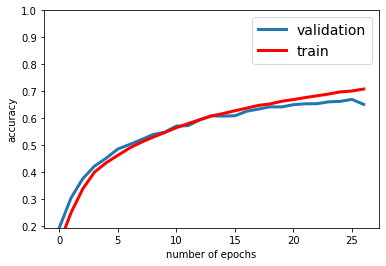

In [ ]:
plt.plot(range(len(train_hist_simple)), train_hist_simple, LW = 3)
plt.plot(range(len(train_hist_simple)), val_hist_simple, color = "red", LW = 3)
plt.legend(["validation","train"], fontsize = 14)
plt.ylim((torch.max(val_hist_simple[0], train_hist_simple[0]).cpu().detach(),1))
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
def compute_accuracy(net, testloader, device):
        # calculating accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Accuracy of the network on test images:{100 * correct / total}")

In [ ]:
compute_accuracy(model_simple, testloader, device)

Accuracy of the network on test images:66.99


In [ ]:
# which classes were classified good and which bad
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_simple(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 88 %
Accuracy of  bird : 48 %
Accuracy of   cat : 38 %
Accuracy of  deer : 56 %
Accuracy of   dog : 49 %
Accuracy of  frog : 71 %
Accuracy of horse : 85 %
Accuracy of  ship : 74 %
Accuracy of truck : 69 %


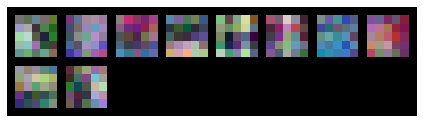

In [ ]:
# viusalisation of filters
model_simple.to('cpu')
# first conv layer
filter = model_simple.conv1.weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

# Somewhat upgraded network

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
model_name = "upgraded"

In [ ]:
model_upgraded, hist_upgraded = train_model(net, dataloaders_dict, criterion,
                                            optimizer, num_epochs=num_epochs + 50)

elo elo
Epoch 1/55
----------

train Loss: 2.3044 Acc: 0.1004

val Loss: 2.3022 Acc: 0.1001

Epoch 2/55
----------

train Loss: 2.3012 Acc: 0.1211

val Loss: 2.3004 Acc: 0.1371

Epoch 3/55
----------

train Loss: 2.2990 Acc: 0.1407

val Loss: 2.2973 Acc: 0.1811

Epoch 4/55
----------

train Loss: 2.2930 Acc: 0.1594

val Loss: 2.2850 Acc: 0.2036

Epoch 5/55
----------

train Loss: 2.2389 Acc: 0.1815

val Loss: 2.1580 Acc: 0.2172

Epoch 6/55
----------

train Loss: 2.0565 Acc: 0.2372

val Loss: 1.9743 Acc: 0.2622

Epoch 7/55
----------

train Loss: 1.9270 Acc: 0.2786

val Loss: 1.8324 Acc: 0.3104

Epoch 8/55
----------

train Loss: 1.8008 Acc: 0.3237

val Loss: 1.7324 Acc: 0.3537

Epoch 9/55
----------

train Loss: 1.7252 Acc: 0.3505

val Loss: 1.6862 Acc: 0.3634

Epoch 10/55
----------

train Loss: 1.6643 Acc: 0.3726

val Loss: 1.6032 Acc: 0.4018

Epoch 11/55
----------

train Loss: 1.6042 Acc: 0.3977

val Loss: 1.5539 Acc: 0.4239

Epoch 12/55
----------

train Loss: 1.5475 Acc: 0.4207


# Updating datasets sizes for pretrained networks

In [ ]:
# Settings
num_classes = 10
batch_size = 64
num_epochs = 5

# loading CIFAR-10 data and transforming it to tensors
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders_dict = {'train':trainloader, 'val':testloader}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])


# Finetuning AlexNet

In [ ]:
# Initialize the model for this run
model_fn_alexnet = initialize_model("alexnet", num_classes,
                                    feature_extract=False, use_pretrained=True)
model_fn_alexnet = model_fn_alexnet.to(device)
optimizer = create_optimizer(model_fn_alexnet, feature_extract=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_fn_alexnet, hist_fn_alexnet = train_model(model_fn_alexnet,
                                                dataloaders_dict, criterion,
                                                optimizer,
                                                num_epochs=num_epochs + 20)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Params to learn:
elo elo
Epoch 1/25
----------


# Future extraction AlexNet

In [ ]:
# Initialize the model for this run
model_fe_alexnet = initialize_model("alexnet", num_classes,
                                    feature_extract=True, use_pretrained=True)
model_fe_alexnet = model_fe_alexnet.to(device)
optimizer = create_optimizer(model_fe_alexnet, feature_extract=True)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_fe_alexnet, hist_fe_alexnet = train_model(model_fe_alexnet,
                                                dataloaders_dict, criterion,
                                                optimizer,
                                                num_epochs=num_epochs)

Params to learn:
Epoch 1/5
----------

train Loss: 0.9536 Acc: 0.6649

val Loss: 0.7362 Acc: 0.7412

Epoch 2/5
----------

train Loss: 0.8176 Acc: 0.7110

val Loss: 0.7055 Acc: 0.7492

Epoch 3/5
----------

train Loss: 0.7836 Acc: 0.7246

val Loss: 0.6788 Acc: 0.7536

Epoch 4/5
----------

train Loss: 0.7708 Acc: 0.7268

val Loss: 0.6608 Acc: 0.7636

Epoch 5/5
----------

train Loss: 0.7557 Acc: 0.7311

val Loss: 0.6347 Acc: 0.7757

Training complete in 4m 50s
Best val Acc: 0.775700


# Training from scratch AlexNet

In [ ]:
# Initialize the model for this run
model_sc_alexnet = initialize_model("alexnet", num_classes,
                                    feature_extract=False, use_pretrained=False)
model_sc_alexnet = model_sc_alexnet.to(device)
optimizer = create_optimizer(model_sc_alexnet, feature_extract=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_sc_alexnet, hist_sc_alexnet = train_model(model_sc_alexnet,
                                                dataloaders_dict, criterion,
                                                optimizer,
                                                num_epochs=num_epochs)

Params to learn:
Epoch 1/5
----------

train Loss: 2.3025 Acc: 0.1045

val Loss: 2.3020 Acc: 0.1380

Epoch 2/5
----------

train Loss: 2.3014 Acc: 0.1205

val Loss: 2.2991 Acc: 0.1448

Epoch 3/5
----------

train Loss: 2.2479 Acc: 0.1507

val Loss: 2.0510 Acc: 0.2657

Epoch 4/5
----------

train Loss: 1.9051 Acc: 0.3032

val Loss: 1.6768 Acc: 0.3836

Epoch 5/5
----------

train Loss: 1.6507 Acc: 0.3906

val Loss: 1.6219 Acc: 0.4059

Training complete in 5m 6s
Best val Acc: 0.405900


# Finetuning VGG

In [ ]:
# Initialize the model for this run
model_fn_vgg = initialize_model("vgg", num_classes, feature_extract=False,
                                use_pretrained=True)
model_fn_vgg = model_fn_vgg.to(device)
optimizer = create_optimizer(model_fn_vgg, feature_extract=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_fn_vgg, hist_fn_vgg = train_model(model_fn_vgg, dataloaders_dict,
                                        criterion, optimizer,
                                        num_epochs=num_epochs)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



Params to learn:
Epoch 1/5
----------

train Loss: 0.5173 Acc: 0.8245

val Loss: 0.2666 Acc: 0.9067

Epoch 2/5
----------

train Loss: 0.2182 Acc: 0.9248

val Loss: 0.2159 Acc: 0.9254

Epoch 3/5
----------

train Loss: 0.1351 Acc: 0.9544

val Loss: 0.2153 Acc: 0.9266

Epoch 4/5
----------

train Loss: 0.0826 Acc: 0.9721

val Loss: 0.2163 Acc: 0.9299

Epoch 5/5
----------

train Loss: 0.0512 Acc: 0.9831

val Loss: 0.2330 Acc: 0.9300

Training complete in 20m 54s
Best val Acc: 0.930000


# Finetuninig Efficientnet

In [ ]:
model_fn_en

NameError: ignored

In [ ]:
# Initialize the model for this run
model_fn_en = initialize_model("efficientnet", num_classes,
                               feature_extract=False, use_pretrained=True)
model_fn_en = model_fn_en.to(device)
optimizer = create_optimizer(model_fn_en, feature_extract=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_fn_en, hist_fn_en = train_model(model_fn_en, dataloaders_dict,
                                      criterion, optimizer,
                                      num_epochs=num_epochs)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
Params to learn:
Epoch 1/5
----------

train Loss: 1.0293 Acc: 0.7330

val Loss: 0.3680 Acc: 0.8882

Epoch 2/5
----------

train Loss: 0.3515 Acc: 0.8871

val Loss: 0.2338 Acc: 0.9243

Epoch 3/5
----------

train Loss: 0.2539 Acc: 0.9159

val Loss: 0.3445 Acc: 0.8899

Epoch 4/5
----------

train Loss: 0.2040 Acc: 0.9319

val Loss: 0.1712 Acc: 0.9451

Epoch 5/5
----------

train Loss: 0.1753 Acc: 0.9426

val Loss: 0.1519 Acc: 0.9485

Training complete in 19m 49s
Best val Acc: 0.948500


# Finetuning Resnet

In [ ]:
# Initialize the model for this run
model_fn_rn = initialize_model("resnet", num_classes,
                               feature_extract=False, use_pretrained=True)
model_fn_rn = model_fn_rn.to(device)
optimizer = create_optimizer(model_fn_rn, feature_extract=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_fn_rn, val_acc_history_rn, train_acc_history_rn = train_model(model_fn_rn, criterion, optimizer, 
                                                                    num_epochs= 10, dataloaders = dataloaders_dict)
                                      
                                      

Params to learn:
Epoch 1/10
----------


KeyboardInterrupt: ignored

# First comparison

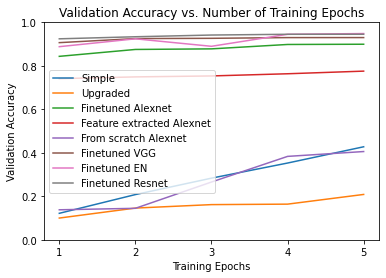

In [ ]:
hists = [hist_simple, hist_upgraded, hist_fn_alexnet, hist_fe_alexnet,
         hist_sc_alexnet, hist_fn_vgg, hist_fn_en, hist_fn_rn]

hist_printable = [[h.cpu().numpy() for h in hist] for hist in hists]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
names = ["Simple", "Upgraded", "Finetuned Alexnet", "Feature extracted Alexnet",
         "From scratch Alexnet", "Finetuned VGG", "Finetuned EN",
         "Finetuned Resnet"]
for hist, name in zip(hist_printable, names):
  plt.plot(range(1,6),hist,label=name)

plt.ylim((0,1.))
plt.xticks(np.arange(1, 6, 1.0))
plt.legend()
plt.show()

# Data augmentation

In [ ]:
transform_train = transforms.Compose([
    # Data augmentation
    transforms.Resize(224),                                
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Settings
num_classes = 10
batch_size = 64
num_epochs = 5


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders_dict = {'train':trainloader, 'val':testloader}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])


In [ ]:
trainloader

## Efficientnet augmented

In [ ]:
# Initialize the model for this run
model_fn_en_aug = initialize_model("efficientnet", num_classes,
                               feature_extract=False, use_pretrained=True)
model_fn_en_aug = model_fn_en_aug.to(device)
optimizer = create_optimizer(model_fn_en_aug, feature_extract=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_fn_en_aug, hist_fn_en_aug = train_model(model_fn_en_aug,
                                              dataloaders_dict,
                                      criterion, optimizer,
                                      num_epochs=num_epochs)

Loaded pretrained weights for efficientnet-b0
Params to learn:
Epoch 1/5
----------

train Loss: 0.9698 Acc: 0.7525

val Loss: 0.5034 Acc: 0.8449

Epoch 2/5
----------

train Loss: 0.3375 Acc: 0.8910

val Loss: 0.2538 Acc: 0.9212

Epoch 3/5
----------

train Loss: 0.2498 Acc: 0.9176

val Loss: 0.1899 Acc: 0.9368

Epoch 4/5
----------

train Loss: 0.2100 Acc: 0.9311

val Loss: 0.1753 Acc: 0.9436

Epoch 5/5
----------

train Loss: 0.1788 Acc: 0.9415

val Loss: 0.1379 Acc: 0.9545

Training complete in 19m 49s
Best val Acc: 0.954500


## Resnet augmented

In [ ]:
# Initialize the model for this run
model_fn_rn_aug = initialize_model("resnet", num_classes,
                               feature_extract=False, use_pretrained=True)
model_fn_rn_aug = model_fn_rn_aug.to(device)
optimizer = create_optimizer(model_fn_rn_aug, feature_extract=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_fn_rn_aug, hist_fn_rn_aug = train_model(model_fn_rn_aug,
                                              dataloaders_dict,
                                      criterion, optimizer,
                                      num_epochs=num_epochs)

Params to learn:
Epoch 1/5
----------

train Loss: 0.4828 Acc: 0.8470

val Loss: 0.2235 Acc: 0.9253

Epoch 2/5
----------

train Loss: 0.1925 Acc: 0.9351

val Loss: 0.1736 Acc: 0.9400

Epoch 3/5
----------

train Loss: 0.1436 Acc: 0.9523

val Loss: 0.1523 Acc: 0.9488

Epoch 4/5
----------

train Loss: 0.1119 Acc: 0.9634

val Loss: 0.1472 Acc: 0.9468

Epoch 5/5
----------

train Loss: 0.0883 Acc: 0.9717

val Loss: 0.1447 Acc: 0.9497

Training complete in 8m 24s
Best val Acc: 0.949700


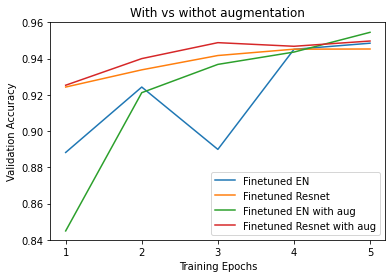

In [ ]:
hists = [hist_fn_en, hist_fn_rn, hist_fn_en_aug, hist_fn_rn_aug]

hist_printable = [[h.cpu().numpy() for h in hist] for hist in hists]

plt.title("With vs withot augmentation")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
names = ["Finetuned EN",
         "Finetuned Resnet",
         "Finetuned EN with aug",
         "Finetuned Resnet with aug"]
for hist, name in zip(hist_printable, names):
  plt.plot(range(1,6),hist,label=name)

plt.ylim((0.84,0.96))
plt.xticks(np.arange(1, 6, 1.0))
plt.legend()
plt.show()

In [ ]:
# Free memory
import gc
del base_estimator
gc.collect()

255

# Ensembling

## Torchensemble - Resnet

In [ ]:
base_estimator = initialize_model("resnet", num_classes,
                               feature_extract=False, use_pretrained=True)
base_estimator = base_estimator.to(device)

# Define the ensemble
model_te= VotingClassifier(estimator=base_estimator,     
                         n_estimators=5)              

# Set the optimizer
model_te.set_optimizer("SGD",                            
                    lr=0.001,
                    momentum=0.9,
                    weight_decay=5e-4)   

# Set the scheduler
#model.set_scheduler("CosineAnnealingLR", T_max=num_epochs) 

# Train
model_te.fit(trainloader,
          epochs=num_epochs)                               
                     

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 2.55175 | Correct: 6/64
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 0.68617 | Correct: 53/64
Estimator: 000 | Epoch: 000 | Batch: 200 | Loss: 0.42145 | Correct: 57/64
Estimator: 000 | Epoch: 000 | Batch: 300 | Loss: 0.40054 | Correct: 53/64
Estimator: 000 | Epoch: 000 | Batch: 400 | Loss: 0.28067 | Correct: 58/64
Estimator: 000 | Epoch: 000 | Batch: 500 | Loss: 0.26995 | Correct: 58/64
Estimator: 000 | Epoch: 000 | Batch: 600 | Loss: 0.16412 | Correct: 60/64
Estimator: 000 | Epoch: 000 | Batch: 700 | Loss: 0.32827 | Correct: 57/64
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 2.53999 | Correct: 9/64
Estimator: 001 | Epoch: 000 | Batch: 100 | Loss: 0.74340 | Correct: 50/64
Estimator: 001 | Epoch: 000 | Batch: 200 | Loss: 0.46787 | Correct: 53/64
Estimator: 001 | Epoch: 000 | Batch: 300 | Loss: 0.45205 | Correct: 53/64
Estimator: 001 | Epoch: 000 | Batch: 400 | Loss: 0.24291 | Correct: 59/64
Estimator: 001 | Epoch: 000 | Batch: 500

RuntimeError: ignored

In [ ]:
# Evaluate
acc = model_te.predict(testloader)
print(acc)  

95.74


## Torchensemble - Efficientnet 

In [ ]:
base_estimator = initialize_model("efficientnet", num_classes,
                               feature_extract=False, use_pretrained=True)
base_estimator = base_estimator.to(device)

# Define the ensemble
model_te_1= VotingClassifier(estimator=base_estimator,     
                         n_estimators=5)              

# Set the optimizer
model_te_1.set_optimizer("SGD",                            
                    lr=0.001,
                    momentum=0.9,
                    weight_decay=5e-4)   

# Set the scheduler
#model.set_scheduler("CosineAnnealingLR", T_max=num_epochs) 

# Train
model_te_1.fit(trainloader, epochs=5)                               
                     

In [ ]:
# Evaluate
acc = model_te_1.predict(testloader)
print(acc)  

RuntimeError: ignored

In [ ]:
model_te_1 = model_te_1.to("cpu")
compute_accuracy(model_te_1, testloader, "cpu") # it was 95.96

Accuracy of the network on test images: 95 %


## Torchensemble - Resnet 32x32 size






In [ ]:
transform_train = transforms.Compose([
    # Data augmentation                           
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Settings
num_classes = 10
batch_size = 64
num_epochs = 10


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_estimator = initialize_model("resnet", num_classes,
                               feature_extract=False, use_pretrained=True)
base_estimator = base_estimator.to(device)

# Define the ensemble
model_te2= VotingClassifier(estimator=base_estimator,     
                         n_estimators=10)              

# Set the optimizer
model_te2.set_optimizer("SGD",                            
                    lr=0.001,
                    momentum=0.9,
                    weight_decay=5e-4)   

# Set the scheduler
model_te2.set_scheduler("CosineAnnealingLR", T_max=num_epochs) 

# Train
model_te2.fit(trainloader,
          epochs=num_epochs) 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 2.52609 | Correct: 12/64
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 1.27002 | Correct: 32/64
Estimator: 000 | Epoch: 000 | Batch: 200 | Loss: 1.27406 | Correct: 33/64
Estimator: 000 | Epoch: 000 | Batch: 300 | Loss: 1.33392 | Correct: 36/64
Estimator: 000 | Epoch: 000 | Batch: 400 | Loss: 0.89985 | Correct: 43/64
Estimator: 000 | Epoch: 000 | Batch: 500 | Loss: 1.06511 | Correct: 40/64
Estimator: 000 | Epoch: 000 | Batch: 600 | Loss: 0.96086 | Correct: 43/64
Estimator: 000 | Epoch: 000 | Batch: 700 | Loss: 1.11457 | Correct: 42/64
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 2.61301 | Correct: 5/64
Estimator: 001 | Epoch: 000 | Batch: 100 | Loss: 1.56528 | Correct: 28/64
Estimator: 001 | Epoch: 000 | Batch: 200 | Loss: 1.14161 | Correct: 41/64
Estimator: 001 | Epoch: 000 | Batch: 300 | Loss: 1.04271 | Correct: 37/64
Estimator: 001 | Epoch: 000 | Batch: 400 | Loss: 0.98793 | Correct: 40/64
Estimator: 001 | Epoch: 000 | Batch: 5

In [ ]:
# Evaluate
acc = model_te2.predict(testloader)
print(acc)  

83.73


# Visualisation

In [ ]:
def visualize_model(model, dataloaders_dict, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

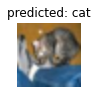

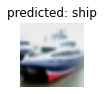

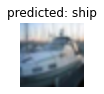

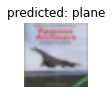

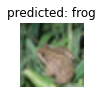

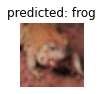

In [ ]:
visualize_model(model_fn_vgg, dataloaders_dict)

# Final results

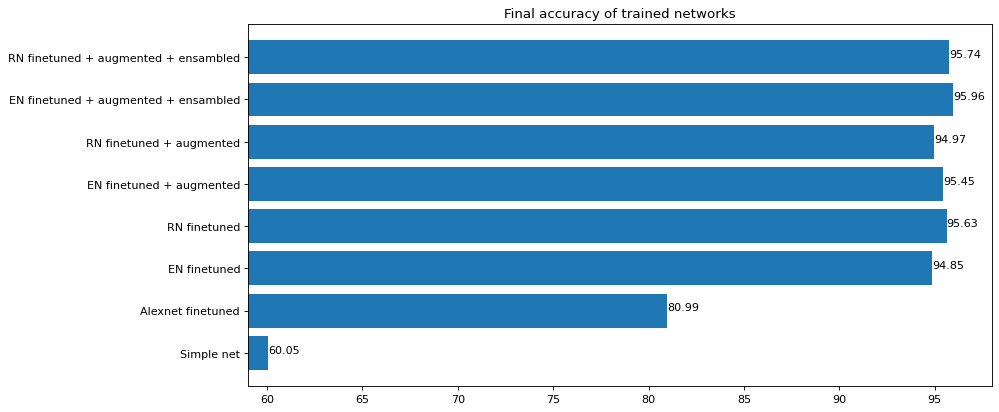

In [ ]:
plt.figure(figsize=(12, 6), dpi=80)
names = ['Simple net', 'Alexnet finetuned', 'EN finetuned', 'RN finetuned', 'EN finetuned + augmented',
         'RN finetuned + augmented', 'EN finetuned + augmented + ensambled',
         'RN finetuned + augmented + ensambled']
vals = [60.05, 80.99, 94.85, 95.63, 95.45, 94.97, 95.96, 95.74]
plt.barh(names,vals)
plt.title('Final accuracy of trained networks')
for index, value in enumerate(vals):
    plt.text(value, index, str(value))
plt.xlim((59,98))
plt.show()